In [1]:
%reset -f
import sys
sys.path.insert(0,'..')
from utils import *
from wavhandler import *
import os
import soundfile as sf
import matplotlib.pyplot as plt
from utils import np_hist
from natsort import natsorted

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


In [2]:
data_plexi = Dataset('Leafminers')
data_plexi.read(data='P_Cichorii_plexibox', setting='psd_dB')
data_plexi.clean(threshold=10)
data_plexi.get_sensor_features(version='1')

Data: P_Cichorii_plexibox.
Read 1693 filenames in 0.10 seconds.
Loaded data into matrix in 0.56 seconds.
1259 filenames after cleaning.


In [3]:
#pd.to_datetime('20190809143432', format='%Y%m%d%H%M%S')

In [4]:
data_mixed = Dataset('Leafminers')
data_mixed.read(data='P_Cichorii', setting='psd_dB')
data_mixed.clean(threshold=10)
data_mixed.get_sensor_features(version='1')#, temp_humd=False)
# data_mixed.y = pd.Series(['Pchic' for i in range(len(data_mixed.y))])

Data: P_Cichorii.
Read 1600 filenames in 0.09 seconds.
Loaded data into matrix in 0.48 seconds.
883 filenames after cleaning.


In [5]:
X = pd.concat([data_plexi.X, data_mixed.X])
# X = X.iloc[:, :79]
y = pd.concat([data_plexi.y, data_mixed.y])
tem = pd.concat([data_plexi.df_features.temperature, data_mixed.df_features.temperature])
tem = pd.cut(tem, bins=[0, 26, 30, 34, 40], labels=['0-26', '26-30', '30-34', '34-40'])
hour = pd.concat([data_plexi.df_features.date_hour, data_mixed.df_features.date_hour])
hour = pd.to_numeric(hour.astype(float))
hour = pd.cut(hour, bins=[0, 7, 14, 17, 23], labels=['0-7', '7-14', '14-17', '17-20'])
hum = pd.concat([data_plexi.df_features.humidity, data_mixed.df_features.humidity])
hum = pd.cut(hum, bins=[0, 35, 50, 65, 80], labels=['0-35', '35-50', '50-65', '65-80'])

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [31]:
month = pd.concat([data_plexi.df_features.date.dt.month, data_mixed.df_features.date.dt.month])
month = pd.to_numeric(month.astype(float))
# month = pd.cut(month, bins=[0, 4, 8, 11], labels=['0-4', '4-8', '8-11'])
month.value_counts()

10.0    1266
2.0      390
4.0      183
3.0      164
5.0       86
6.0       34
1.0       14
7.0        5
Name: date, dtype: int64

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

lr = LogisticRegression(solver='lbfgs', n_jobs=-1)
lr.fit(X,y)
score = cross_val_score(lr, X, y, cv=5)
print("Cross_val_score: {},\nmean: \t\t{}".format(score, np.mean(score)))

Cross_val_score: [0.94405594 0.88811189 0.7972028  0.91121495 0.92740047],
mean: 		0.8935972102051464


In [8]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import xgboost
#xgboost.XGBClassifier
clf = RandomForestClassifier(n_estimators=150, 
#                                    learning_rate=0.2, 
                                   n_jobs=-1,
#                                    class_weight={0:5., 1:1., 2:1., 3:1.},
                                   random_state=0)

clf.fit(X_train, y_train)
# y_pred = clf.predict(df_test.values)
score = cross_val_score(clf, X, y, cv=5)
print("Cross_val_score: {},\nmean: \t\t{}".format(score, np.mean(score)))

Cross_val_score: [0.97902098 0.99067599 0.95337995 0.88551402 0.99297424],
mean: 		0.9603130361288781


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import xgboost
from tqdm import tqdm

scores_lr, scores_rf = {}, {}
for i in tqdm(range(1,130)):
    X = pd.concat([data_plexi.X, data_mixed.X])
    X = X.iloc[:, :i]
    y = pd.concat([data_plexi.y, data_mixed.y])

    clf_lr = LogisticRegression(solver='lbfgs', n_jobs=-1)
    clf_lr.fit(X,y)
    score_lr = np.mean(cross_val_score(clf_lr, X, y, cv=3))
    scores_lr[i] = score_lr
    
    clf_rf = RandomForestClassifier(n_estimators=150, n_jobs=-1, random_state=0)
    clf_rf.fit(X,y)
    score_rf = np.mean(cross_val_score(clf_rf, X, y, cv=3))
    scores_rf[i] = score_rf

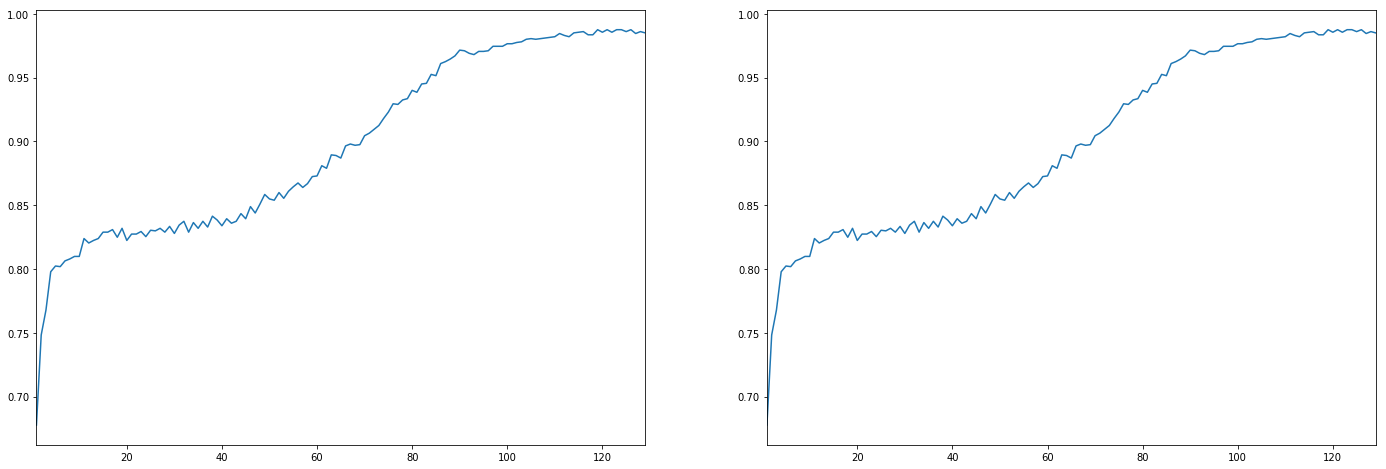

In [22]:
plt.figure(figsize=(24,8))
plt.subplot(1,2,1)
pd.Series(scores_lr, index=scores_lr.keys()).plot()
plt.subplot(1,2,2)
pd.Series(scores_rf, index=scores_rf.keys()).plot()

In [18]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import xgboost
from tqdm import tqdm

scores2_lr, scores2_rf = {},{}
for i in tqdm(range(1,125)):
    X = pd.concat([data_plexi.X, data_mixed.X])
    X = X.iloc[:, i:i+5]
    y = pd.concat([data_plexi.y, data_mixed.y])

    clf_lr = LogisticRegression(solver='lbfgs', n_jobs=-1)
    score2_lr = np.mean(cross_val_score(clf, X, y, cv=3))
    scores2_lr[i] = score2_lr
    
    clf_rf = RandomForestClassifier(n_estimators=150, n_jobs=-1, random_state=0)
    clf_rf.fit(X,y)
    score2_rf = np.mean(cross_val_score(clf_rf, X, y, cv=3))
    scores2_rf[i] = score2_rf

100%|██████████| 124/124 [02:31<00:00,  1.13s/it]


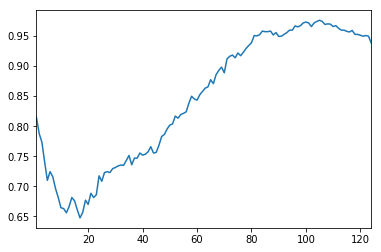

In [19]:
pd.Series(scores2, index=scores2.keys()).plot()

In [ ]:
# from rfpimp import *
# from rfpimp import *
# import pandas as pd
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split

# X_test.columns = X_test.columns.astype(str)
# imp = importances(clf, X_test, y_test) # permutation
# imp = imp.reindex(index=natsorted(imp.index))
# viz = plot_importances(imp)
# viz.view()
# imp.plot()

#### Make samples of features (moving window selecting few frequencies) and see classification performance. Then you will understand which frequencies drive more the changes between Plexi data and Original/Mixed

### Trying PCA

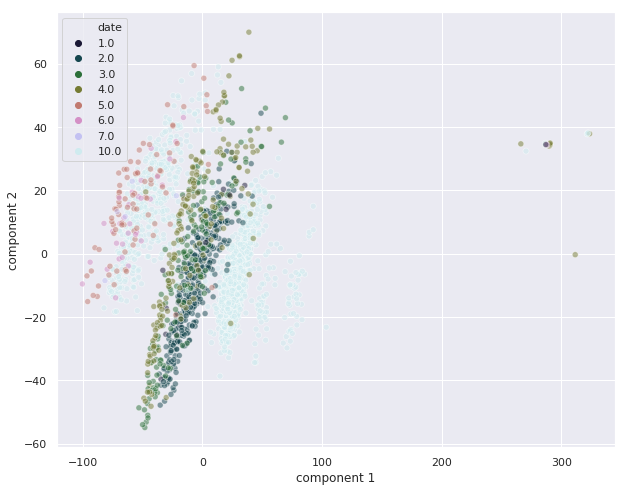

In [33]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

X_std = StandardScaler(with_std=False).fit_transform(X)  # standardization of data

rbf_pca = PCA(n_components=2)

X_final = rbf_pca.fit_transform(X_std)

plt.figure(figsize=(10,8))
sns.scatterplot(X_final[:,0], X_final[:,1],
                alpha=0.5, 
                legend='full', 
                hue=month, 
                palette=sns.color_palette("cubehelix", 8)) 
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.show()

In [17]:
lr = LogisticRegression(solver='lbfgs', n_jobs=-1)
lr.fit(X_final, y)
cross_val_score(lr, X_final, y, cv=3)

array([0.47552448, 0.56302521, 0.66058906])

### Trying Kernel PCA 

The kernel trick is a mathematical technique that implicitly maps instances into a very high-dimensional space (called the feature space), enabling nonlinea classification and regression for Support Vector Machines.
A linear decision boundary in the high-dimensional feature space corresponds to a complex nonlinear decision boundary in the original space. 
Applying the Kernel trick to PCA, making it possile to perform complex nonlinear projections for dimensionality reduction. It is often good at preserving clusters of instances after projections, or sometimes even unrolling datasets that lie close to a twisted manifold.

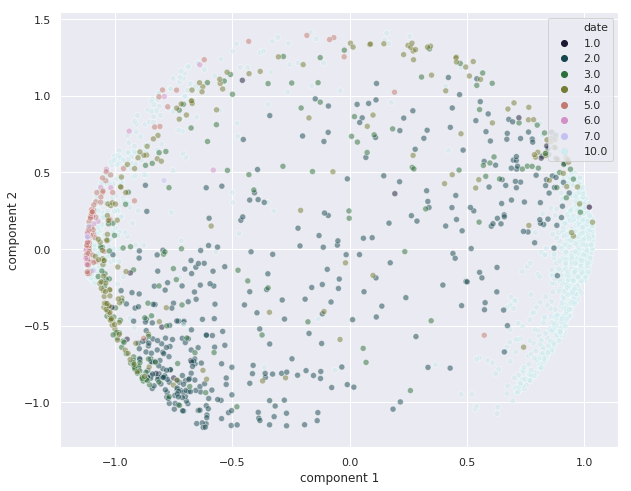

In [35]:
from sklearn.decomposition import KernelPCA

X_std = StandardScaler(with_std=False).fit_transform(X)  # standardization of data

rbf_pca = KernelPCA(n_components=2, kernel="sigmoid")

X_final = rbf_pca.fit_transform(X_std)

plt.figure(figsize=(10,8))
sns.scatterplot(X_final[:,0], X_final[:,1],alpha=0.5, legend='full', 
                hue=month,
                palette=sns.color_palette("cubehelix", 8)) 
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.show()

In [19]:
lr = LogisticRegression(solver='lbfgs', n_jobs=-1)
lr.fit(X_final, y)
cross_val_score(lr, X_final, y, cv=3)

array([0.56923077, 0.63305322, 0.65217391])

### Trying LLE (Locally Linear Embedding)

LLE does not rely on projections like the previous algorithms. In a nutshell, LLE works by first measuring how each training instance linearly relates to its closest neighbors, and then looking for a low-dimensional representation of the training set where these local relationships are best preserved. This makes it particularly good at unrolling twisted manifolds, especially when there is too much noise.

In [20]:
from sklearn.manifold import LocallyLinearEmbedding

In [21]:
X_std = StandardScaler(with_std=False).fit_transform(X)  # standardization of data

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=50)
X_final = lle.fit_transform(X_std)

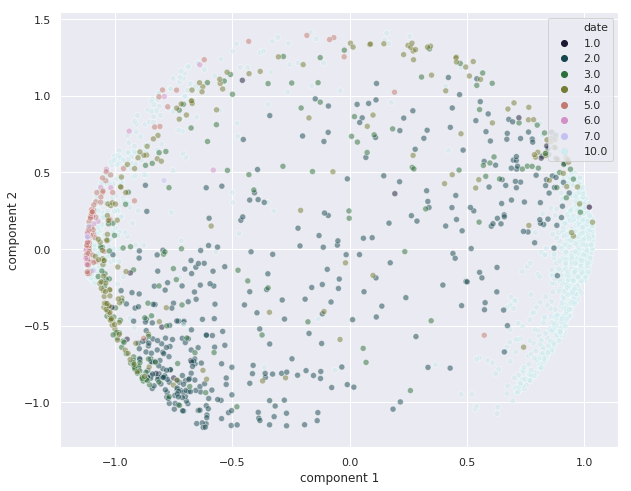

In [37]:
plt.figure(figsize=(10,8))
sns.scatterplot(X_final[:,0], X_final[:,1],alpha=0.5, legend='full', 
                hue=month, 
                palette=sns.color_palette("cubehelix", 8)) 
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.show()

In [38]:
lr = LogisticRegression(solver='lbfgs', n_jobs=-1)
lr.fit(X_final, y)
cross_val_score(lr, X_final, y, cv=3)

array([0.56923077, 0.63305322, 0.65217391])

### Trying t-SNE

In [39]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [40]:
n_components = 2
learning_rate = 300
perplexity = 50
early_exaggeration = 12
init='random'
random_state = 2018

tSNE = TSNE(n_components=n_components, learning_rate=learning_rate, \
           perplexity=perplexity, early_exaggeration=early_exaggeration, \
           init=init, random_state=random_state)

In [41]:
X_std = StandardScaler(with_std=True).fit_transform(X)  # standardization of data

X_final = tSNE.fit_transform(X_std)

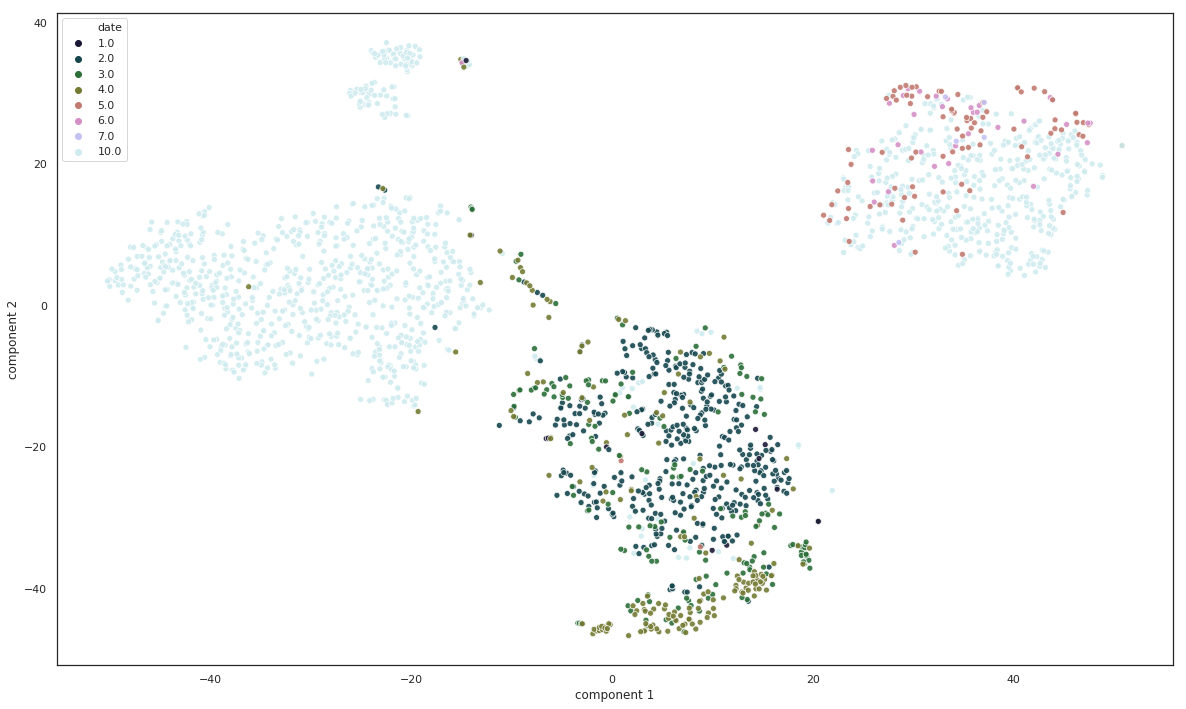

In [46]:
sns.set_style("white")

plt.figure(figsize=(20,12))
sns.scatterplot(X_final[:,0], X_final[:,1],alpha=0.9, legend='full', 
                hue=month, 
                palette=sns.color_palette("cubehelix", 8))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.show()

In [28]:
lr = LogisticRegression(solver='lbfgs', n_jobs=-1)
lr.fit(X_final, y)
cross_val_score(lr, X_final, y, cv=3)

array([0.87412587, 0.84033613, 0.86395512])